In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family': 'sans serif'})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 1.5})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'xtick.major.size': 5})
plt.rcParams.update({'xtick.major.width': 1.25 })
plt.rcParams.update({'xtick.minor.size': 2.5})
plt.rcParams.update({'xtick.minor.width': 1.25 })
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'ytick.major.size': 5})
plt.rcParams.update({'ytick.major.width': 1.25 })
plt.rcParams.update({'ytick.minor.size': 2.5})
plt.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

from IPython import display

T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

import h5py

import glob
import os
os.chdir("/Users/helenarichie/GitHub/analysis_scripts/")
from cholla_py_utils import ChollaPyUtils
os.chdir("/Users/helenarichie/GitHub/research/cholla/dust_model/cloud-wind/")
cholla_helper = ChollaPyUtils()

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [101]:
def plotter(outdir, quantity, nplots=5, figsize=(10, 15), slices=True, save=False):

    def load_data(outdir):
        if slices:
            files = sorted(glob.glob(os.path.join(outdir, "*slice.h5.0")))
        else:
            files = sorted(glob.glob(os.path.join(outdir, "*.h5.0")))
            
        # total number of output files
        n_out = len(files)

        nx, ny, nz = None, None, None
        dx, dy, dz = None, None, None

        t_arr = []

        d_gas, d_dust = [], []

        vx = []
        T, P = [], []
        
        n = []
        
        i_out = np.arange(0, n_out)

        units = set()

        for i in i_out:
            f = h5py.File(outdir + str(i) + ".h5.0", "r")
            head = f.attrs
            a_group_key = list(f.keys())

            # conversion between whatever units the code was run in and cgs units
            units.add(head['length_unit'][0])
            units.add(head['time_unit'][0])
            units.add(head['mass_unit'][0])
            units.add(head['density_unit'][0])
            units.add(head['velocity_unit'][0])
            units.add(head['energy_unit'][0])

            # number of cells in each direction
            nx = head['dims'][0]
            ny = head['dims'][1]
            nz = head['dims'][2]

            # dimensions of cells in cgs units
            dx = cholla_helper.l_cgs(head['dx'][0])
            dy = cholla_helper.l_cgs(head['dx'][0])
            dz = cholla_helper.l_cgs(head['dx'][0])

            # time in cgs units
            t_arr.append(np.array(cholla_helper.t_cgs(head["t"])/cholla_helper._YR_IN_S))

            # mass density in cgs units
            d_gas.append(np.array(cholla_helper.d_cgs(np.array(f["density"]))))
            d_dust.append(np.array(cholla_helper.d_cgs(np.array(f["scalar0"]))))

            # mass density in code units
            d_gas_ch = np.array(f["density"])

            # x, y, and z momentum in code units
            mx_ch = np.array(f["momentum_x"])
            my_ch = np.array(f["momentum_y"])
            mz_ch = np.array(f["momentum_z"])
            
            # total energy density in code units
            E_ch = np.array(f["Energy"])
            
            # x, y, and z velocity in code units
            vx_ch = mx_ch / d_gas_ch
            vy_ch = my_ch / d_gas_ch
            vz_ch = mz_ch / d_gas_ch

            # x velocity in cgs units
            vx.append(vx_ch/cholla_helper._VELOCITY_UNIT)
            
            # temperature in cgs units
            T.append(np.array(cholla_helper.calc_T(E_ch, vx_ch, vy_ch, vz_ch, d_gas_ch)))
            
            # pressure in cgs units
            P.append(np.array(cholla_helper.calc_P_cgs(T[i], cholla_helper.calc_n_cgs(d_gas[i]))))

            # number density, particles per cm^3
            n.append(d_gas[i]/(cholla_helper._mu*cholla_helper._MP))

        return [t_arr, d_gas, d_dust, T, P, n, [nx, ny, nz], [dx, dy, dz], vx, units, n_out]

    # read data from cholla output HDF5 file
    data = load_data(outdir)

    t_arr = np.array(data[0])
    d_gas = np.array(data[1])
    d_dust = np.array(data[2])
    T = np.array(data[3])
    n = np.array(data[5])
    nx, ny, nz = data[6][0], data[6][1], data[6][2] 
    dx, dy, dz = data[7][0], data[7][1], data[7][2]
    vx = data[8]
    n_out = data[10]
    
    fig, axs = plt.subplots(nplots, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 2]})
    
    ylabel = None
    title = None
    plot_data_x = None
    plot_data_y = None
    
    # get indices of output to plot (assumes at least 5 files)
    plot_ind = np.linspace(0, n_out-1, nplots).astype(int)
    
    if quantity == "gas":
        if slices:
            plot_data = d_gas[plot_ind]
            title = "Gas Density"
            ylabel = r'$\mathrm{log}_{10}(\rho)~[\mathrm{g}\mathrm{cm}^{-3}$]'
        else:
            # x projection
            plot_data_x = np.sum(d_gas[plot_ind], axis=1)*dx
            # y projection
            plot_data_y = np.sum(d_gas[plot_ind], axis=2)*dx
            title = "Gas Surface Density"
            ylabel = r'$\mathrm{log}_{10}(\rho)~[\mathrm{g}\mathrm{cm}^{-2}$]'
    if quantity == "dust":
        if slices:
            plot_data_x = d_dust[:, :, int(nx/2)].squeeze()
        else:
            # x projection
            plot_data_x = np.sum(d_dust[plot_ind], axis=1)*dx
            # y projection
            plot_data_y = np.sum(d_dust[plot_ind], axis=2)*dx
            title = "Dust Surface Density"
            ylabel = r'$\mathrm{log}_{10}(\rho)~[\mathrm{g}\mathrm{cm}^{-2}$]'
    if quantity == "velocity":
        plot_data = vx[plot_ind]
        title = "x Velocity"
        ylabel = f"$v~[km/s]$"
    if quantity == "temp":
        plot_data = T[plot_ind]
        title = "Temperature"
        ylabel = f"$T~[K]$"

    t_sub = t_arr[plot_ind]

    for i, i_out in enumerate(plot_ind):
        # plot x-axis slice or projection
        if not quantity == "dust":
            log_x = np.log10(plot_data_x[i])
        else:
            log_x = plot_data_x[i]

        axs[i][0].set_xticks(ny*np.arange(0.25, 1, 0.25))
        axs[i][0].set_yticks(nz*np.arange(0.25, 1, 0.25))
        axs[i][0].tick_params(axis='both', which='both', direction='in', color='white', top=1, right=1)
        axs[i][0].set_xlabel(r"$y$")
        axs[i][0].set_ylabel(r"$z$")
        
        axs[i][0].imshow(log_x.T, origin='lower', cmap='viridis', label="$Time={:.1e}~yr$".format(t_sub[i][0]))
        axs[i][0].text(10, 15, '$Time={:.1e}~yr$'.format(t_sub[i][0]), bbox={'facecolor': 'white', 'pad': 8}, fontsize=10, alpha=0.6)
        
        # plot y-axis slice or projection
        if not quantity == "dust":
            log_y = np.log10(plot_data_y[i])
        else:
            log_y = plot_data_y[i]
        
        axs[i][1].set_xticks(nx*np.arange(0.25, 1, 0.25))
        axs[i][1].set_yticks(nz*np.arange(0.25, 1, 0.25))
        axs[i][1].tick_params(axis='both', which='both', direction='in', color='white', top=1, right=1)
        axs[i][1].set_xlabel(r"$x$")
        axs[i][1].set_ylabel(r"$z$")
        
        image = axs[i][1].imshow(log_y.T, origin='lower', cmap='viridis', label="$Time={:.1e}~yr$".format(t_sub[i][0]))
        axs[i][1].text(10, 15, '$Time={:.1e}~yr$'.format(t_sub[i][0]), bbox={'facecolor': 'white', 'pad': 8}, fontsize=10, alpha=0.6)
         
        # add colorbar
        cbar = fig.colorbar(image, ax=axs[i][1])
        cbar.set_label(ylabel)
        
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(title, y=0.91, fontsize=16)
    if save:
        plt.savefig(os.path.join("/Users/helenarichie/GitHub/helenarichie.github.io/assets/img/posts", quantity,))

# 10 km/s

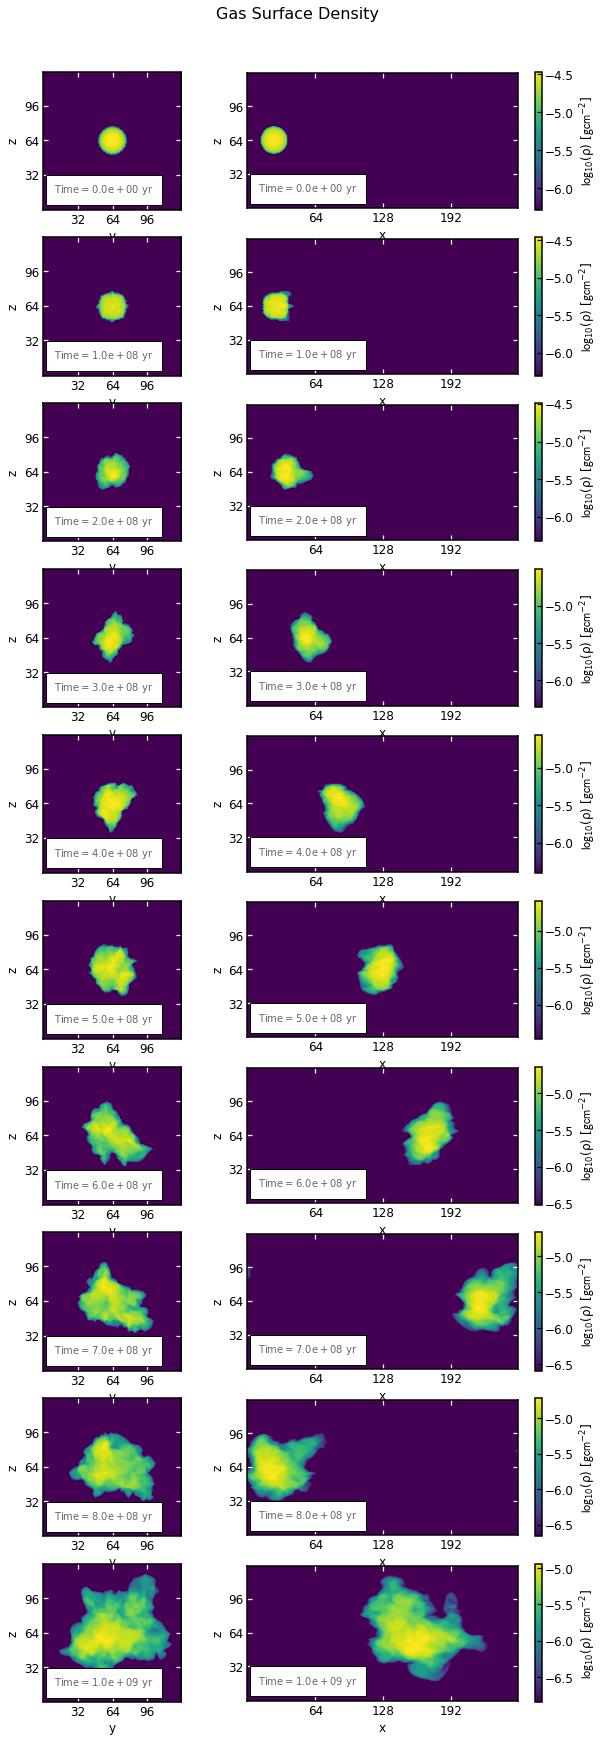

In [112]:
plotter("cholla_out/v10/", "gas", nplots=10, figsize=(10, 30), slices=False, save=True)

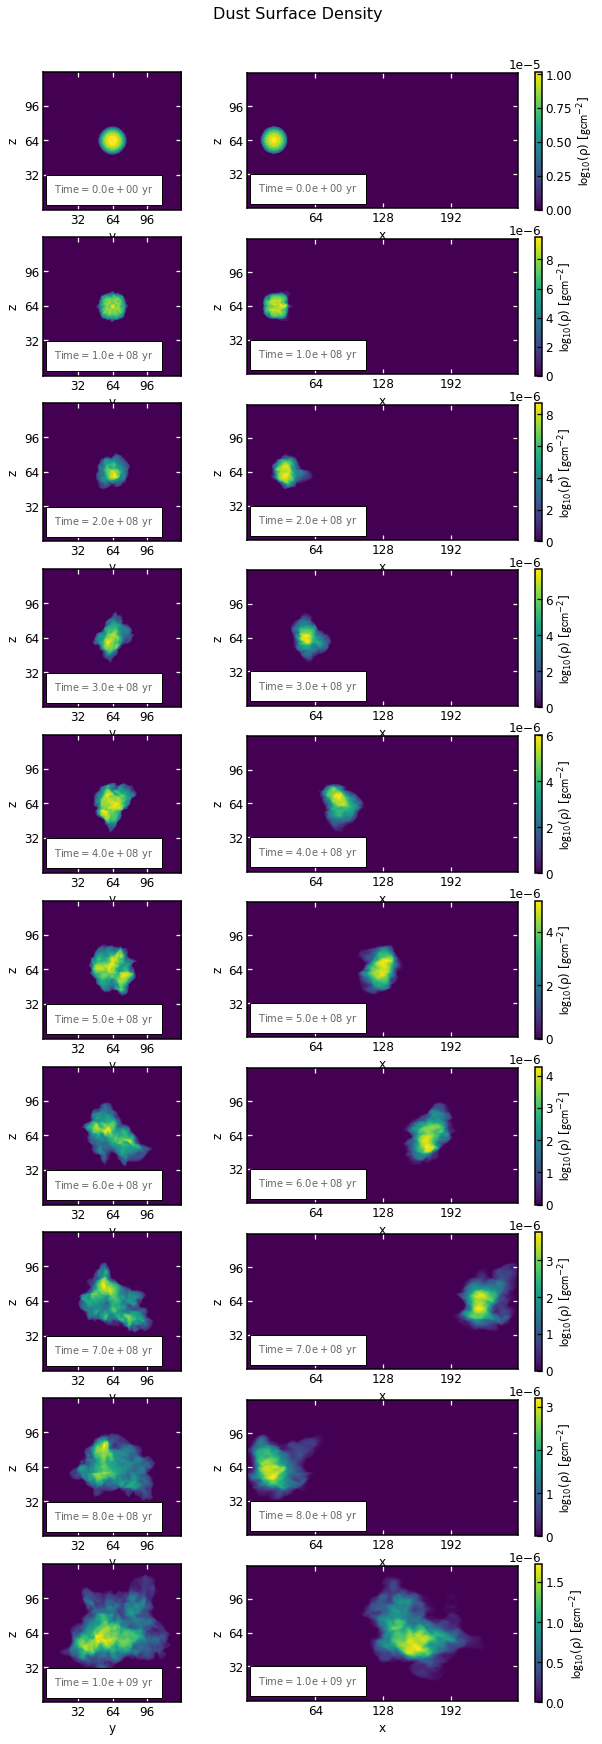

In [106]:
plotter("cholla_out/v10/", "dust", nplots=10, figsize=(10, 30), slices=False, save=True)

# 1e2 km/s

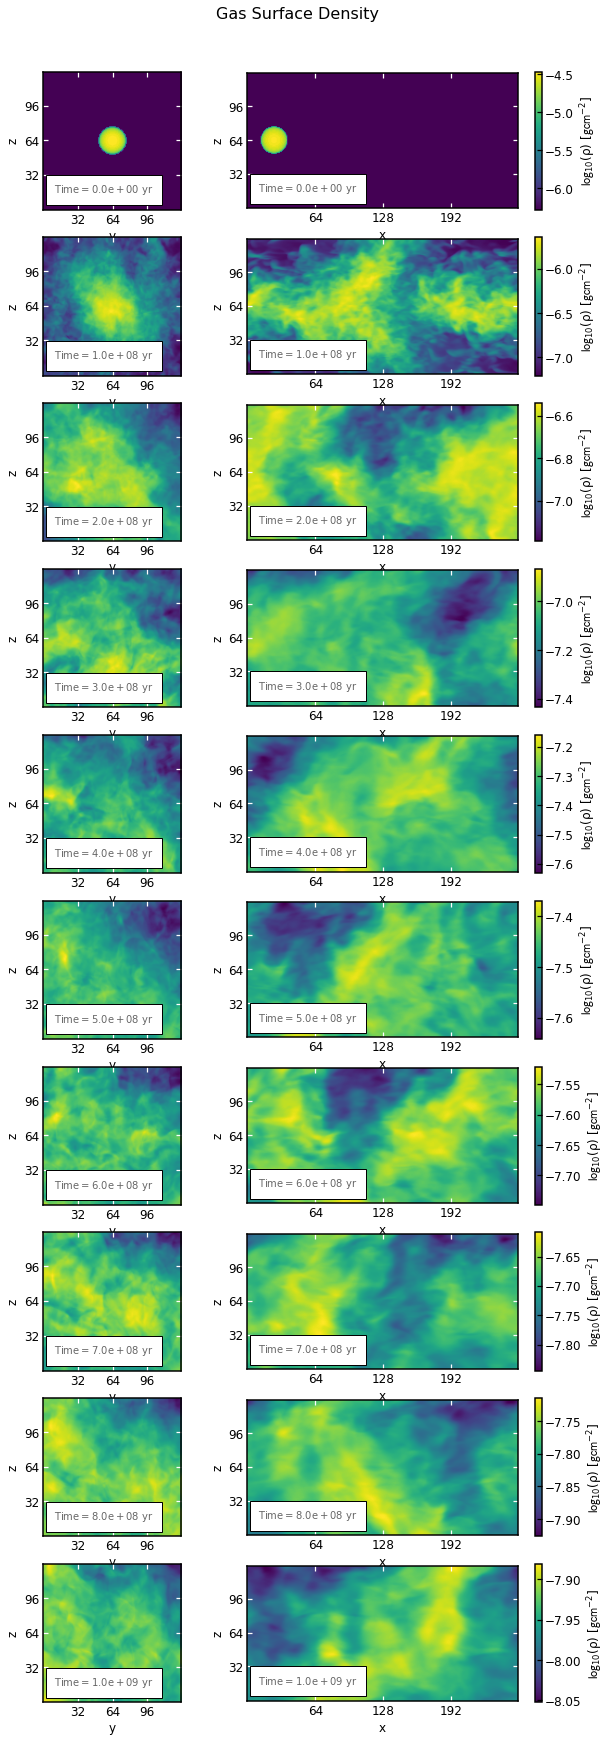

In [115]:
plotter("cholla_out/v100/", "gas", nplots=10, figsize=(10, 30), slices=False)

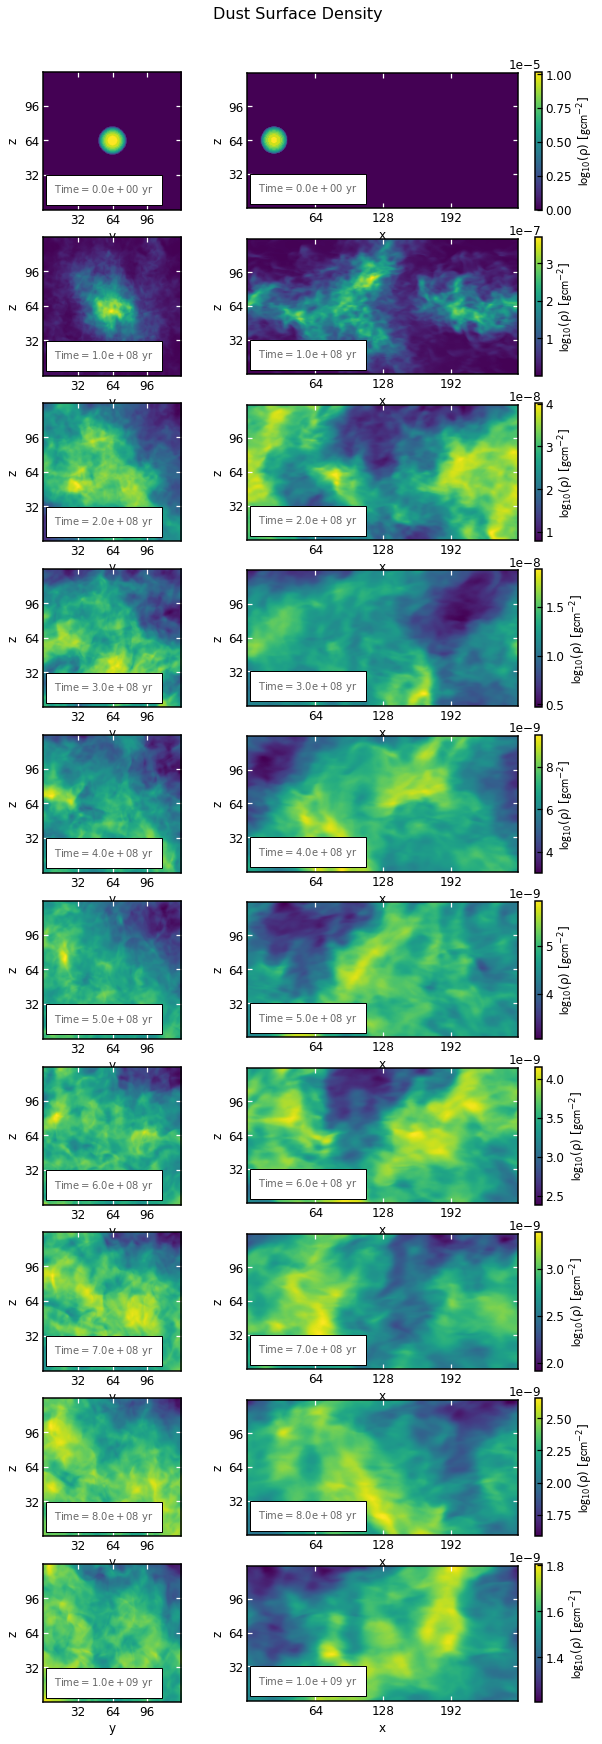

In [116]:
plotter("cholla_out/v100/", "dust", nplots=10, figsize=(10, 30), slices=False)

# 1e3 km/s

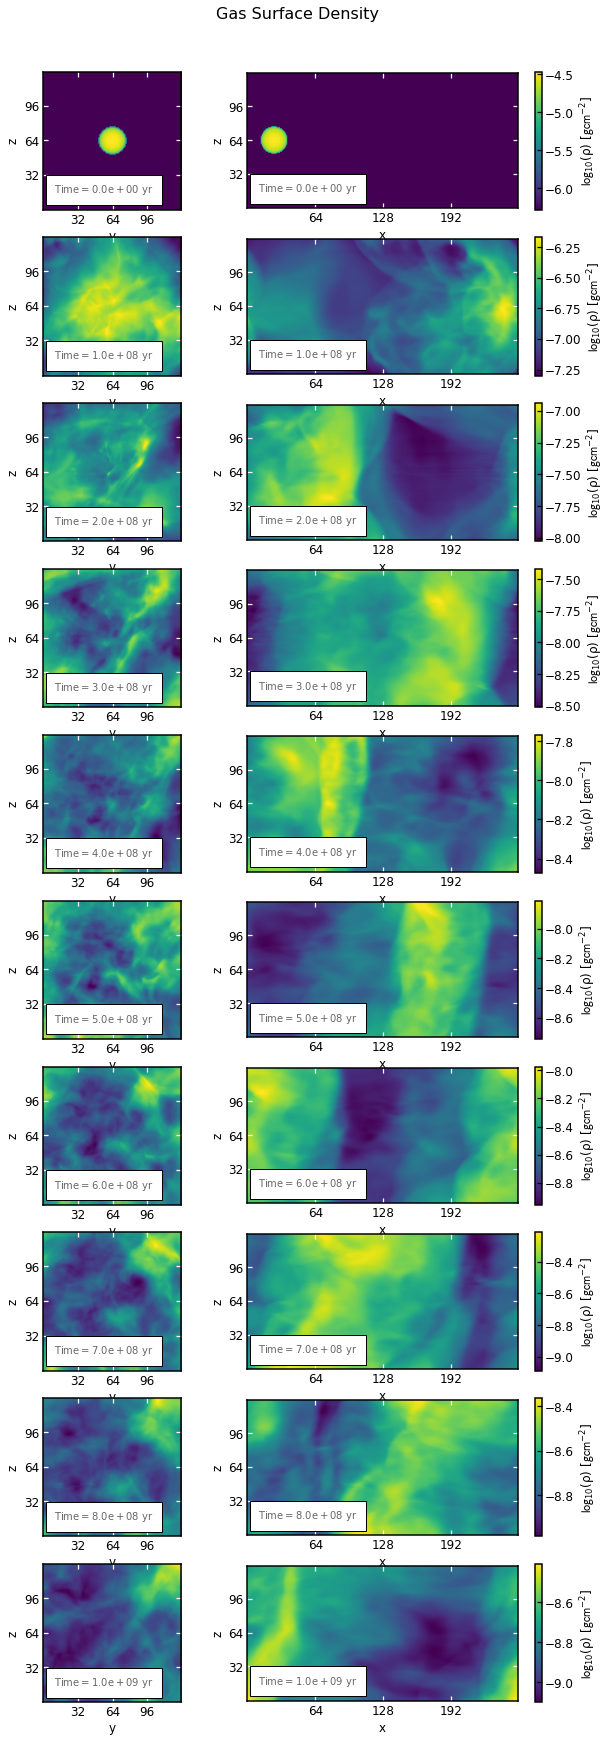

In [110]:
plotter("cholla_out/v1000/", "gas", nplots=10, figsize=(10, 30), slices=False)

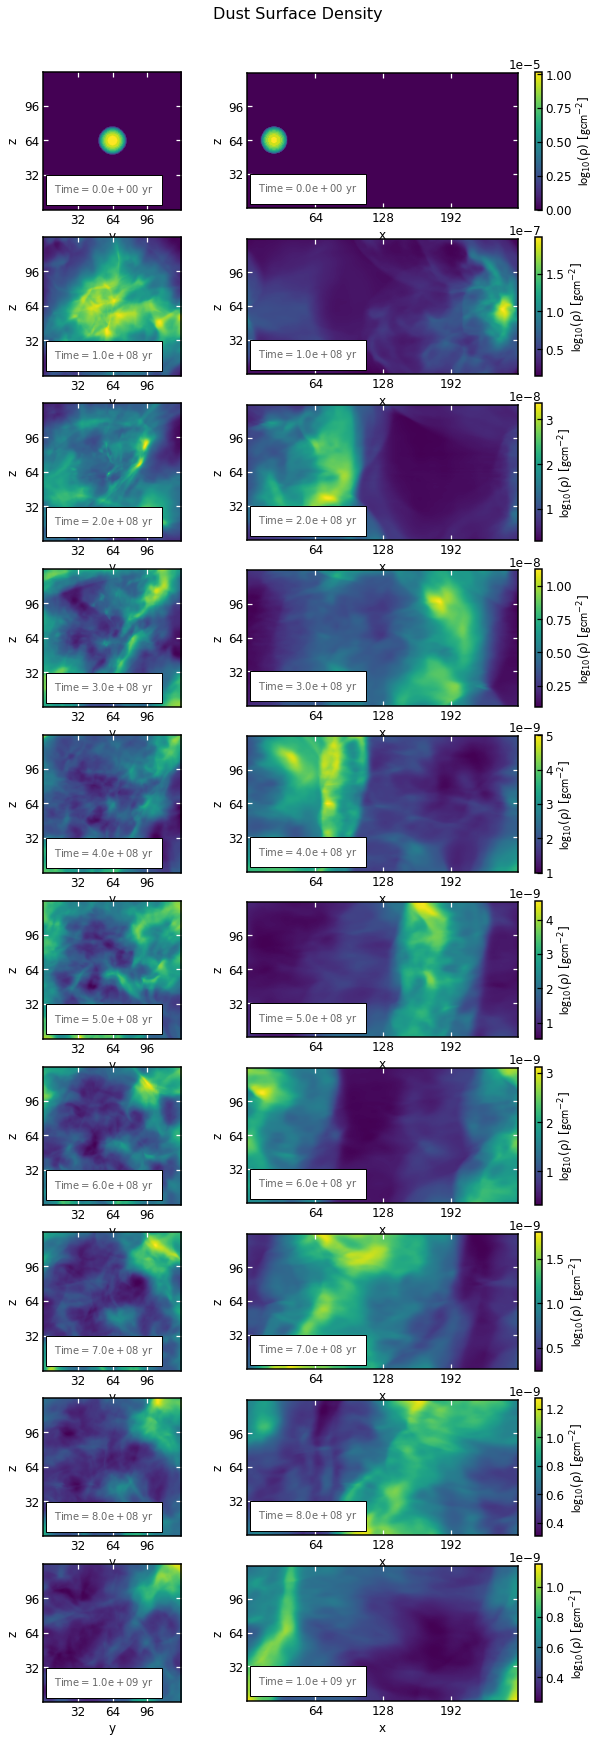

In [111]:
plotter("cholla_out/v1000/", "dust", nplots=10, figsize=(10, 30), slices=False)